# Regression 
We'll try to follow the following model to make a regression:<br>
$ price = f (points, year, province, region_1, variety, winery) $

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *

import xgboost as xgb

from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow import keras

from imblearn.over_sampling import *

In [15]:
df = pd.read_csv('data/winedata.csv',index_col='index')
df = shuffle(df)
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
33587,Israel,Fresh but concentrated all at once with rich a...,Sha'al Single Vineyard Late Harvest Kosher - 3...,88,24.0,Galilee,NaN,NaN,Lauren Buzzeo,@laurbuzz,Carmel 2006 Sha'al Single Vineyard Late Harves...,Gewürztraminer,Carmel
77912,US,"Aromas and flavors of fig, earth and mushroom ...",Cloud Buster,85,29.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Manzanita Creek 2013 Cloud Buster Zinfandel (R...,Zinfandel,Manzanita Creek
67593,US,"Light in color and weight, this is a nicely co...",Hopkins Vineyard,88,20.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,River Road 2012 Hopkins Vineyard Pinot Meunier...,Pinot Meunier,River Road
112040,US,"Charred black plum, cola and licorice aromas s...",Rodney's Vineyard,89,35.0,California,Santa Barbara County,Central Coast,Matt Kettmann,@mattkettmann,Epiphany 2014 Rodney's Vineyard Petite Sirah (...,Petite Sirah,Epiphany
85299,Italy,"Pipe tobacco, exotic spice, mature black-skinn...",Lilium Est Riserva,90,NaN,Veneto,Amarone della Valpolicella,NaN,Kerin O’Keefe,@kerinokeefe,Tenuta Sant'Antonio 2007 Lilium Est Riserva (...,Red Blend,Tenuta Sant'Antonio


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 33587 to 104801
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


<AxesSubplot:>

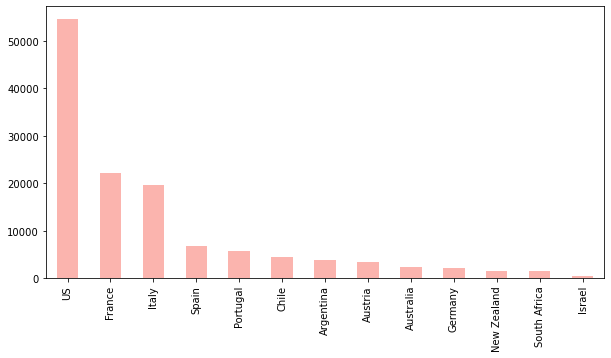

In [17]:
#Keep the country with atleast 500 wines

df = df[df['country'].isin(df['country'].value_counts()[df['country'].value_counts()>500].index)]

df_country = df['country'].value_counts()
df_country.plot(kind='bar',figsize=(10,5),cmap='Pastel1')

In [18]:
#Extract the year from the title column
df['year'] = df['title'].str.extract('(\d{4})',expand=False)
df.dropna(subset=['year'],inplace=True)
df['year'] = df['year'].astype(int)

#keep only the years between 1970 and 2022
df = df[df['year']>1970]
df = df[df['year']<2022]

df['year'].describe()

count    123172.000000
mean       2010.688152
std           3.571744
min        1973.000000
25%        2009.000000
50%        2011.000000
75%        2013.000000
max        2017.000000
Name: year, dtype: float64

In [19]:
#Drop unecessary columns
df.drop(['description','designation','taster_twitter_handle','taster_name','region_2','title','country'],axis=1, inplace=True)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97308 entries, 77912 to 104801
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   points    97308 non-null  int64  
 1   price     97308 non-null  float64
 2   province  97308 non-null  object 
 3   region_1  97308 non-null  object 
 4   variety   97308 non-null  object 
 5   winery    97308 non-null  object 
 6   year      97308 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 5.9+ MB


In [39]:
#tranformation in number for categorical features

codes_prov, uniques = pd.factorize(df['province'])
df['province'] = codes_prov

codes_reg1, uniques = pd.factorize(df['region_1'])
df['region_1'] = codes_reg1

codes_var, uniques = pd.factorize(df['variety'])
df['variety'] = codes_var

codes_win, uniques = pd.factorize(df['winery'])
df['winery'] = codes_win

df


,points,price,province,region_1,variety,winery,year
77912,85,29.0,0,0,0,0,2013
67593,88,20.0,0,0,1,1,2012
112040,89,35.0,0,1,2,2,2014
115267,90,125.0,0,2,3,3,2014
57526,88,18.0,0,3,4,4,2013
...,...,...,...,...,...,...,...
25914,87,45.0,13,30,19,12142,2012
49984,90,18.0,1,26,24,379,2011
80540,92,36.0,0,112,11,2778,2008
94782,93,75.0,1,14,9,1745,2010


### correct imbalance of the dataset & split in training and testing sets

In [48]:
X = df.drop('price',axis=1).values
y = df['price'].values

transformer = RandomOverSampler()

X, y = transformer.fit_resample(X, y)

scaler = RobustScaler()

X = scaler.fit_transform(X)

print(np.shape(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

(1938209, 6)


## XGBoost

In [56]:
model_xgb = xgb.XGBRegressor()

model_xgb.fit(X_train, y_train, verbose=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [58]:
pred_xgb = model_xgb.predict(X_test)

print('RMSE:',np.sqrt(mean_squared_error(y_test, pred_xgb)))
print('R2:',explained_variance_score(y_test, pred_xgb))

RMSE: 31.794478655072417
R2: 0.9913631913247789


In [62]:
#DNN with tensorflow


ann = Sequential([
    layers.Dense(6, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

ann.compile(optimizer='adam', loss='mse')

In [66]:
ann.fit(x=X_train, y=y_train, epochs=200, 
    batch_size=124,
    validation_data=(X_test,y_test),
    callbacks=EarlyStopping(monitor='val_loss',patience=0))

Epoch 1/200
10473/10473 [==============================] - 21s 2ms/step - loss: 7413.5903 - mse: 7413.5903 - val_loss: 5945.9810 - val_mse: 5945.9810
Epoch 2/200
10473/10473 [==============================] - 21s 2ms/step - loss: 5122.0571 - mse: 5122.0571 - val_loss: 4771.1436 - val_mse: 4771.1436
Epoch 3/200
10473/10473 [==============================] - 22s 2ms/step - loss: 4268.4668 - mse: 4268.4668 - val_loss: 3862.5818 - val_mse: 3862.5818
Epoch 4/200
10473/10473 [==============================] - 23s 2ms/step - loss: 3777.4529 - mse: 3777.4529 - val_loss: 3387.3674 - val_mse: 3387.3674
Epoch 5/200
10473/10473 [==============================] - 26s 2ms/step - loss: 3535.3628 - mse: 3535.3628 - val_loss: 3070.7947 - val_mse: 3070.7947
Epoch 6/200
10473/10473 [==============================] - 25s 2ms/step - loss: 3159.7310 - mse: 3159.7310 - val_loss: 3090.2222 - val_mse: 3090.2222
Epoch 7/200
10473/10473 [==============================] - 23s 2ms/step - loss: 2883.0898 - mse: 288

<AxesSubplot:>

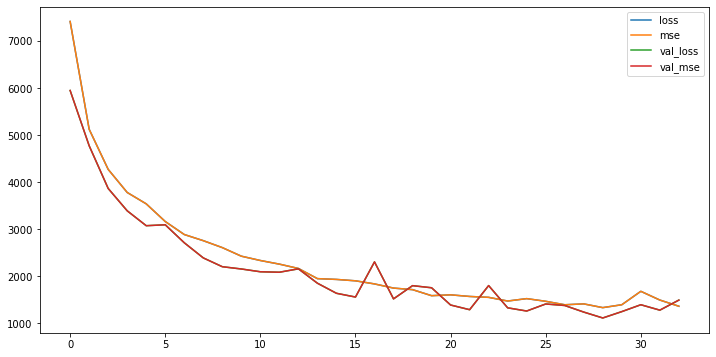

In [67]:
pd.DataFrame(ann.history.history).plot(figsize=(12,6))

In [69]:
pred_ann = ann.predict(X_test)

#print regression score and mean squared error
print("MSE:", np.sqrt(mean_squared_error(y_test, pred_ann)))
print("R2:",r2_score(y_test, pred_ann))

19988/19988 [==============================] - 15s 728us/step
MSE: 38.58890857691225
R2: 0.99


In [70]:
df['price'].describe().T

count    97308.000000
mean        37.146072
std         42.251007
min          4.000000
25%         18.000000
50%         28.000000
75%         45.000000
max       3300.000000
Name: price, dtype: float64